In [1]:
# -*- coding: utf-8 -*-

'''
@Author   :   Corley Tang
@contact  :   cutercorleytd@gmail.com
@Github   :   https://github.com/corleytd
@Time     :   2023-03-20 14:11
@Project  :   Hands-on Deep Learning with PyTorch-modeling_objective_and_model_underfitting_in_deep_learning
深度学习建模目标与模型欠拟合
'''

# 导入所需的库
import random

import numpy as np
import torch
from matplotlib import pyplot as plt
from sklearn.datasets import load_breast_cancer as LBC
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import random_split, Dataset, DataLoader

from utils.data_gen_split import gen_reg_data, gen_cls_data, data_split_batches

# 设置随机种子
random.seed(2023032114)
np.random.seed(2023032114)
torch.manual_seed(2023032114)

## 1.深度学习建模目标与数据处理
### 机器学习目标与模型评估方法
前面使用了准确率、MSE等指标评估建模结果，看起来模型评估是围绕某项指标在进行评估，指标好模型就好、指标不好模型就不好，其实并不完全如此。要了解模型的性能其实并不简单，固然我们会使用某些指标去进行模型评估，但其实指标也只是我们了解模型性能的途径而不是模型性能本身。而要真实、深刻的评判模型性能，就必须首先了解机器学习的建模目标，并在此基础之上熟悉我们判断模型是否能够完成目标的一些方法，只有真实了解的模型性能，我们才能进一步考虑如何提升模型性能。
无论是机器学习还是传统的统计分析模型，核心使命就是探索数字规律，而有监督学习则是希望在探索数字规律的基础上进一步对未来进行预测。正是因为模型有了在未知标签情况下进行预判的能力，有监督学习才有了存在的价值，但我们知道，基本上所有的模型，都只能从以往的历史经验当中进行学习，也就是在以往的、已经知道的数据集上进行训练，这里的核心矛盾在于，在以往的数据中提取出来的经验（也就是模型）怎么证明能够在接下来的数据中也具备一定的预测能力，即要怎么训练模型才能让模型在未知的数据集上也拥有良好的表现。
数理统计分析和机器学习的对比如下：

（1）统计分析领域，往往会假设现在的数据和未来的数据其实都属于某个存在但不可获得的总体，也就是说，现在和未来的数据都是从某个总体中抽样而来的，都是这个总体的样本。而正是因为这些数据属于同一个总体，因此具备某些相同的规律，而现在挖掘到的数据规律也就在某些程度上可以应用到未来的数据当中去，不过不同抽样的样本之间也会有个体之间的区别，另外模型本身也无法完全捕获规律，而这些就是误差的来源。虽然样本和总体的概念是统计学概念，但样本和总体的概念所假设的前后数据的“局部规律一致性”，却是所有机器学习建模的基础。无论是机器学习所强调的从业务角度出发，要确保前后数据描述的一致性，还是统计分析所强调的样本和总体的概念，都是建模的基础。有了假设基础之后，统计分析就会利用一系列的数学方法和数理统计工具去推导总体的基本规律，也就是变量的分布规律和一些统计量的取值，由于这个过程是通过已知的样本去推断未知的总体，因此会有大量的**估计**和**检验**，在确定了总体的基本分布规律之后，才能够进一步使用统计分析模型构建模型，当然，这些模型都是在总体规律基础之上、根据样本具体的数值进行的建模，我们自然有理由相信这些模型对接下来仍然是从总体中抽样而来的样本还是会具备一定的预测能力，这也就是我们对统计分析模型“信心”的来源。简单来说，就是我们通过样本推断总体的规律，然后结合总体的规律和样本的数值构建模型，由于模型也描绘了总体规律，所以模型对接下来从总体当中抽样而来的数据也会有不错的预测效果。流程如下图所示。

![statistical_analysis_process](../assets/statistical_analysis_process.png)

（2）机器学习并没有借助“样本-总体”的基本理论，而是简单采用了一种后验的方法来判别模型有效性，前面假设前后获取的数据拥有规律一致性，但数据彼此之间又略有不同，**为了能够在捕捉规律的同时又能考虑到“略有不同”所带来的误差，机器学习会把当前能获取到的数据划分成训练集和测试集，在训练集上构建模型，然后带入测试集的数据，观测在测试集上模型预测结果和真实结果之间的差异**。这个过程其实就是在模拟获取到真实数据之后模型预测的情况，模型能够在未知标签的数据集上进行预测，这就是模型的核心价值，此时的测试集就是用于模拟未来的未知标签的数据集。如果模型能够在测试集上有不错的预测效果，我们就“简单粗暴”地认为模型可以在真实的未来获取的未知数据集上有不错的表现。虽然对比起数理统计分析，机器学习的证明模型有效性的过程更加“简单”，毕竟只要一次“模拟”成功，我们就认为模型对未来的数据也拥有判别效力，但这种“简单”的处理方式却非常实用，可以说，这是一种经过长期实践被证明的行之有效的方法。这也是为什么机器学习很多时候也被认为是实证类的方法，可以说机器学习有很多方法都是“经验总结的结果”。相比数理统计分析，确实没有“那么严谨”，但更易于理解的理论和更通用的方法，却使得机器学习可以在更为广泛的应用场景中发挥作用。模型在训练集上误差称为训练误差，在测试集上的误差称为泛化误差，不过毕竟在测试集上进行测试还只是模拟演习，我们采用模型的泛化能力来描述模型在未知数据上的判别能力，只能通过模型在训练集和测试集上的表现判别模型泛化能力，最基本的就是通过模型在测试集上的表现来判断模型的泛化能力。流程如下图所示。

![machine_learning_process](../assets/machine_learning_process.png)
### 手动划分训练集和测试集

In [2]:
def train_test_split(features, labels, train_ratio=0.8, shuffle=True):
    '''
    划分训练集和测试集
    :param features: 特征张量
    :param labels: 标签张量
    :param train_ratio: 训练集占所有数据的比例
    :param shuffle: 切分前是否随机打乱数据
    :return: 特征和标签的划分结果
    '''
    num_samples = features.shape[0]  # 总数据量
    indices = list(range(num_samples))  # 数据索引
    if shuffle:
        random.shuffle(indices)  # 随机打乱索引
    num_train = int(num_samples * train_ratio)  # 训练集数量
    train_indices = torch.tensor(indices[:num_train])  # 训练集索引
    test_indices = torch.tensor(indices[num_train:])  # 测试集索引
    X_train, X_test = features[train_indices], features[test_indices]  # 训练集和测试集特征张量
    y_train, y_test = labels[train_indices], labels[test_indices]  # 训练集和测试集标签张量
    return X_train, X_test, y_train, y_test

In [3]:
# 测试函数
features = torch.arange(10)
labels = torch.arange(10, 20)
train_test_split(features, labels)

(tensor([6, 1, 7, 9, 4, 8, 2, 0]),
 tensor([3, 5]),
 tensor([16, 11, 17, 19, 14, 18, 12, 10]),
 tensor([13, 15]))

In [4]:
# 利用自定义函数生成数据进行建模
features, labels = gen_reg_data()
features.shape, labels.shape

(torch.Size([1000, 3]), torch.Size([1000]))

In [5]:
# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(features, labels)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 3]),
 torch.Size([200, 3]),
 torch.Size([800]),
 torch.Size([200]))

In [6]:
# 模型、损失函数和优化算法
def lin_reg(X, w):
    return X @ w


def mse(y_hat, y):
    return (y_hat - y).square().sum() / y_hat.size(0)


def sgd(params, lr):
    params.data -= lr * params.grad
    params.grad.zero_()

In [7]:
# 设置超参数
lr = 0.03
num_epochs = 5
batch_size = 16

# 初始化权重参数
w = torch.randn(3, requires_grad=True)

# 定义模型与损失函数
model = lin_reg
criterion = mse

# 迭代训练
for epoch in range(num_epochs):
    for X, y in data_split_batches(batch_size, features, labels):
        y_hat = model(X, w)
        loss = criterion(y_hat, y)
        loss.backward()
        sgd(w, lr)
    epoch_loss = criterion(model(features, w), labels)
    print(f'epoch {epoch} loss: {epoch_loss.item():.4f}')

# 查看最终得到的参数
w

epoch 0 loss: 0.0012
epoch 1 loss: 0.0001
epoch 2 loss: 0.0001
epoch 3 loss: 0.0001
epoch 4 loss: 0.0001


tensor([9.9957e-01, 9.9965e-01, 2.9713e-04], requires_grad=True)

In [8]:
# 查看在训练集和测试集上的MSE
criterion(model(X_train, w), y_train), criterion(model(X_test, w), y_test)  # 两个损失都较小，模型效果较好

(tensor(0.0001, grad_fn=<DivBackward0>),
 tensor(8.7378e-05, grad_fn=<DivBackward0>))

### Dataset与DataLoader的基本使用

In [9]:
# random_split随机切分
data = torch.randn(10, 2)
train_data, test_data = random_split(data, [8, 2])  # 切分结果的生成器
train_data.indices, test_data.indices

([8, 7, 2, 4, 3, 6, 5, 0], [1, 9])

相比于TensorDataset，更通用的数据读取和处理的做法是先利用Dataset类和DataLoader类完成数据的读取、预处理和加载，再使用random_split函数切分数据集流程如下。

![dataset_dataloader_process](../assets/dataset_dataloader_process.png)

In [10]:
# 自定义乳腺癌数据集——来自sklearn
class LBCDataset(Dataset):  # 继承自Dataset类
    def __init__(self, data):  # 初始化方法
        self.features = data.data  # 数据集特征
        self.labels = data.target  # 数据集标签

    def __getitem__(self, index):  # 返回给定索引时对应的特征和标签
        return self.features[index], self.labels[index]

    def __len__(self):  # 返回数据集大小
        return self.features.shape[0]


# 实例化数据集
data = LBC()
lbc_data = LBCDataset(data)
len(lbc_data)  # 数据集长度

569

In [11]:
# 查看指定索引的数据：包含特征和标签
lbc_data[3], data.data[3], data.target[3]  # 与原始数据一致

((array([1.142e+01, 2.038e+01, 7.758e+01, 3.861e+02, 1.425e-01, 2.839e-01,
         2.414e-01, 1.052e-01, 2.597e-01, 9.744e-02, 4.956e-01, 1.156e+00,
         3.445e+00, 2.723e+01, 9.110e-03, 7.458e-02, 5.661e-02, 1.867e-02,
         5.963e-02, 9.208e-03, 1.491e+01, 2.650e+01, 9.887e+01, 5.677e+02,
         2.098e-01, 8.663e-01, 6.869e-01, 2.575e-01, 6.638e-01, 1.730e-01]),
  0),
 array([1.142e+01, 2.038e+01, 7.758e+01, 3.861e+02, 1.425e-01, 2.839e-01,
        2.414e-01, 1.052e-01, 2.597e-01, 9.744e-02, 4.956e-01, 1.156e+00,
        3.445e+00, 2.723e+01, 9.110e-03, 7.458e-02, 5.661e-02, 1.867e-02,
        5.963e-02, 9.208e-03, 1.491e+01, 2.650e+01, 9.887e+01, 5.677e+02,
        2.098e-01, 8.663e-01, 6.869e-01, 2.575e-01, 6.638e-01, 1.730e-01]),
 0)

In [12]:
# 切分数据集
train_ratio = 0.8
num_samples = len(lbc_data)
num_train = int(num_samples * train_ratio)
num_test = num_samples - num_train
num_train, num_test

(455, 114)

In [13]:
lbc_train, lbc_test = random_split(lbc_data, [num_train, num_test])
lbc_train, lbc_test

(<torch.utils.data.dataset.Subset at 0x23fb36e5910>,
 <torch.utils.data.dataset.Subset at 0x23fb36e5340>)

In [14]:
# Subset类对象有2个属性，dataset和indices，分别用于查看原数据集对象和切分后数据集对应原来数据集的索引
lbc_train.dataset, lbc_train.dataset == lbc_data

(<__main__.LBCDataset at 0x23fb36fd250>, True)

In [15]:
lbc_train.indices[:30]

[480,
 553,
 154,
 422,
 252,
 242,
 521,
 411,
 256,
 25,
 404,
 147,
 465,
 509,
 317,
 144,
 238,
 398,
 123,
 280,
 420,
 108,
 240,
 519,
 497,
 385,
 121,
 353,
 463,
 426]

In [16]:
lbc_train[-1], lbc_data[412]  # 对比数据，切分前后一致

((array([1.701e+01, 2.026e+01, 1.097e+02, 9.043e+02, 8.772e-02, 7.304e-02,
         6.950e-02, 5.390e-02, 2.026e-01, 5.223e-02, 5.858e-01, 8.554e-01,
         4.106e+00, 6.846e+01, 5.038e-03, 1.503e-02, 1.946e-02, 1.123e-02,
         2.294e-02, 2.581e-03, 1.980e+01, 2.505e+01, 1.300e+02, 1.210e+03,
         1.111e-01, 1.486e-01, 1.932e-01, 1.096e-01, 3.275e-01, 6.469e-02]),
  0),
 (array([9.397e+00, 2.168e+01, 5.975e+01, 2.688e+02, 7.969e-02, 6.053e-02,
         3.735e-02, 5.128e-03, 1.274e-01, 6.724e-02, 1.186e-01, 1.182e+00,
         1.174e+00, 6.802e+00, 5.515e-03, 2.674e-02, 3.735e-02, 5.128e-03,
         1.951e-02, 4.583e-03, 9.965e+00, 2.799e+01, 6.661e+01, 3.010e+02,
         1.086e-01, 1.887e-01, 1.868e-01, 2.564e-02, 2.376e-01, 9.206e-02]),
  1))

In [17]:
# 使用DataLoader类装载数据，使数据可建模
batch_size = 16
train_loader = DataLoader(lbc_train, batch_size, shuffle=True)
test_loader = DataLoader(lbc_test, batch_size * 2)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x23fb36e5190>,
 <torch.utils.data.dataloader.DataLoader at 0x23fb36e53d0>)

In [18]:
# 根据DataLoader类对象查看原始数据集
train_loader.dataset

In [19]:
train_loader.dataset == lbc_train

True

### 使用Dataset与DataLoader进行建模

In [20]:
# 1.准备数据
# 自定义Dataset
class GenDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

    def __len__(self):
        return self.features.shape[0]


# 生成回归数据并创建数据集对象
features, labels = gen_reg_data()
features = features[..., :-1]
labels.unsqueeze_(-1)
data = GenDataset(features, labels)

# 切分数据集
train_ratio = 0.8
num_samples = len(features)
num_train = int(num_samples * train_ratio)
num_test = num_samples - num_train
train_data, test_data = random_split(data, [num_train, num_test])

# 加载数据
batch_size = 16
train_loader = DataLoader(train_data, batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size * 2)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x23fb3714d30>,
 <torch.utils.data.dataloader.DataLoader at 0x23fb3714d60>)

In [21]:
# 2.构建模型
# 定义模型类
class LR(nn.Module):
    def __init__(self, in_features=2, out_features=1):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        out = self.linear(x)
        return out


# 实例化模型
model = LR()

# 定义损失函数
criterion = nn.MSELoss()

# 定义优化器
lr = 0.03
optimizer = optim.SGD(model.parameters(), lr=lr)


# 迭代训练
def fit(model, criterion, optimizer, data_loader, num_epochs=5):
    for epoch in range(num_epochs):
        for X, y in data_loader:
            y_hat = model(X)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        epoch_loss = criterion(model(data[train_data.indices][0]), data[train_data.indices][1])
        print(f'epoch: {epoch} loss: {epoch_loss.item():.4f}')

In [22]:
# 3.模型训练与测试
num_epochs = 5
fit(model, criterion, optimizer, train_loader, num_epochs=num_epochs)

epoch: 0 loss: 0.0065
epoch: 1 loss: 0.0001
epoch: 2 loss: 0.0001
epoch: 3 loss: 0.0001
epoch: 4 loss: 0.0001


In [23]:
# 查看模型参数
list(model.parameters())

[Parameter containing:
 tensor([[1.0000, 1.0006]], requires_grad=True),
 Parameter containing:
 tensor([-2.9943e-05], requires_grad=True)]

In [24]:
# 查看训练集和测试集上的损失
criterion(model(data[train_data.indices][0]), data[train_data.indices][1]), criterion(model(data[test_data.indices][0]),
                                                                                      data[test_data.indices][1])

(tensor(9.6255e-05, grad_fn=<MseLossBackward0>),
 tensor(0.0001, grad_fn=<MseLossBackward0>))

### 使用函数封装

In [25]:
# 1.数据封装、切分和加载
def split_load_data(dataset_class, features, labels, batch_size=16, train_ratio=0.8):
    '''
    数据封装、切分和加载
    :param features: 特征
    :param labels: 标签
    :param batch_size: 批大小
    :param train_ratio: 训练集数据占比
    :return: 加载好的训练集和测试集
    '''
    data = dataset_class(features, labels)
    num_samples = len(features)
    num_train = int(num_samples * train_ratio)
    num_test = num_samples - num_train
    train_data, test_data = random_split(data, [num_train, num_test])
    train_loader = DataLoader(train_data, batch_size, shuffle=True)
    test_loader = DataLoader(test_data, batch_size * 2)
    return train_loader, test_loader

In [26]:
# 测试函数
features, labels = gen_reg_data()
features = features[..., :-1]
labels.unsqueeze_(-1)
train_loader, test_loader = split_load_data(GenDataset, features, labels, batch_size, train_ratio)
len(train_loader.dataset), train_loader.dataset[0]

(800, (tensor([-1.3556, -0.9212]), tensor([-2.2908])))

In [27]:
# 2.损失计算
def loss_with_loader(model, data_loader, criterion):
    '''
    对整个数据集计算损失
    :param model: 模型
    :param data_loader: 加载好的数据
    :return: 损失值
    '''
    data = data_loader.dataset
    X = data[:][0]
    y = data[:][1]
    y_hat = model(X)
    return criterion(y_hat, y)

In [28]:
# 3.迭代训练
def fit_one_epoch(model, criterion, optimizer, data_loader, cla=False):
    '''
    模型训练一轮
    :param model: 待训练的模型
    :param criterion: 损失函数
    :param optimizer: 优化算法
    :param data_loader: 数据
    :param cla: 是否是分类任务
    :return: None
    '''
    for X, y in data_loader:
        optimizer.zero_grad()
        y_hat = model(X)
        if cla:
            y = y.int()
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()


def fit(model, criterion, optimizer, data_loader, num_epochs=5, cla=False):
    '''
    模型训练
    :param model: 待训练的模型
    :param criterion: 损失函数
    :param optimizer: 优化算法
    :param data_loader: 数据
    :param num_epochs: 数据迭代次数
    :param cla: 是否是分类任务
    :return: None
    '''
    for epoch in range(num_epochs):
        fit_one_epoch(model, criterion, optimizer, data_loader, cla)
        epoch_loss = loss_with_loader(model, data_loader, criterion)
        print(f'epoch: {epoch} loss: {epoch_loss.item():.4f}')

In [29]:
# 测试
lr = 0.03
model = LR()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

fit(model, criterion, optimizer, train_loader)

epoch: 0 loss: 0.0039
epoch: 1 loss: 0.0001
epoch: 2 loss: 0.0001
epoch: 3 loss: 0.0001
epoch: 4 loss: 0.0001


In [30]:
# 比较训练集和测试集的损失
loss_with_loader(model, train_loader, criterion), loss_with_loader(model, test_loader, criterion)

(tensor(0.0001, grad_fn=<MseLossBackward0>),
 tensor(0.0001, grad_fn=<MseLossBackward0>))

In [31]:
# 4.计算准确率
def accuracy(data_loader, model):
    data = data_loader.dataset
    X = data[:][0]
    y = data[:][1]
    z_hat = model(X)
    sigma = F.softmax(z_hat, -1)
    acc = torch.argmax(sigma, -1).flatten() == y.flatten()
    acc = acc.float().mean()
    return acc

In [32]:
# 测试
# 生成数据
features, labels = gen_cls_data(num_classes=3)
labels.squeeze_()
# 数据加载
train_loader, test_loader = split_load_data(GenDataset, features, labels)


# 定义模型
class SoftmaxRegression(nn.Module):
    def __init__(self, in_features=2, out_features=3):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        out = self.linear(x)
        return out


# 实例化模型
model = SoftmaxRegression()

# 定义损失函数和优化器
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# 迭代训练
fit(model, criterion, optimizer, train_loader)

epoch: 0 loss: 0.4066
epoch: 1 loss: 0.3649
epoch: 2 loss: 0.3396
epoch: 3 loss: 0.3224
epoch: 4 loss: 0.3106


In [33]:
# 查看训练集和测试集上的准确率
accuracy(train_loader, model), accuracy(test_loader, model)

(tensor(0.8892), tensor(0.8900))

## 2.模型拟合度介绍
### 测试集的不可知悖论
机器学习模型主要通过模型在测试集上的运行效果来判断模型好坏，在机器学习领域，严格意义上的测试集是不能参与建模的，此处不能参与建模，不仅是指在训练模型时不能带入测试集进行训练，更是指当模型训练完成之后、观察模型在测试集上的运行结果后，也不能据此再进行模型修改（比如增加神经网络层数），因为把数据带入模型训练是影响模型参数，而根据模型运行结果再进行模型结构调整，实际上是修改了模型超参数，不管是修改参数还是超参数，都是影响了模型建模过程，都相当于是带入进行了建模。如果通过观察测试集结果再调整模型结构，也相当于是带入测试集数据进行训练，而严格意义上的测试集，是不能带入模型训练的。

而机器学习建模的核心目标就是提升模型的泛化能力，泛化能力指的是在模型未知数据集（没带入进行训练的数据集）上的表现，虽然测试集只能测一次，但还是希望有机会能把模型带入未知数据集进行测试，此时我们就需要一类新的数据集——验证集。验证集在模型训练阶段不会带入模型进行训练，但当模型训练结束之后，我们会把模型带入验证集进行计算，通过观测验证集上模型运行结果，判断模型是否要进行调整，验证集也会模型训练，只不过验证集训练的不是模型参数，而是模型超参数。我们可以把验证集看成是应对高考的“模拟考试”，通过“模拟考试”的考试结果来调整复习策略，从而更好地应对“高考”。总的来说，测试集是严格不能带入训练的数据集，在实际建模过程中我们可以先把测试集切分出来，然后“假装这个数据集不存在”，在剩余的数据集中划分训练集和验证集，把训练集带入模型进行运算，再把验证集放在训练好的模型中运行，观测运行结果，再进行模型调整。

因此，在模型训练和观测模型运行结果的过程总共涉及三类数据集，分别是训练集、验证集和测试集。不过由于测试集定位特殊，在一些不需要太严谨的场景下，有时也会混用验证集和测试集的概念，在要求不那么严谨的情况下可以不做测试集和验证集的区分。在不区分验证集和测试集的情况下，当数据集切分完成后，对于一个模型来说，我们能够获得两套模型运行结果，一个是训练集上模型效果，一个是测试集上模型效果，而这组结果就将是整个模型优化的基础数据。
### 模型拟合度与实验
在模型优化的所有问题中，模型的拟合度是最基础也最核心的问题，模型如果能很好的捕捉总体规律，就能够有较好的未知数据的预测效果，但限制模型捕捉总体规律的原因主要有两点：
- 样本数据能否很好的反应总体规律
    如果样本数据本身无法很好的反应总体规律，那建模的过程就算捕捉到了规律可能也无法适用于未知数据。举个极端的例子，在进行反欺诈检测时，如果要基于并未出现过欺诈案例的历史数据来进行建模，那模型就将面临无规律可捕捉的窘境，当然，确切的说，是无可用规律可捕捉；或者，当扰动项过大时，噪声也将一定程度上掩盖真实规律。
- 样本数据能反应总体规律，但模型没有捕捉到
    机器学习模型评估主要依据模型在测试集上的表现，如果测试集效果不好，则我们认为模型还有待提升，但导致模型在测试集上效果不好的原因其实也主要有两点，其一是模型没捕捉到训练集上数据的规律，其二则是模型过分捕捉训练集上的数据规律，导致模型捕获了大量训练集独有的、无法适用于总体的规律（局部规律），而测试集也是从总体中来，这些规律也不适用于测试集。前一种情况称模型为欠拟合，后一种情况称模型为过拟合。

In [34]:
# 构造数据
num_dots = 20
x = np.linspace(0, 1, num_dots)
y = np.sqrt(x) + 0.2 * np.random.rand(num_dots) - 0.1  # 拟合y=sqrt(x)
x, y

(array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
        0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
        0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
        0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
 array([0.08406603, 0.18633599, 0.32778196, 0.36831305, 0.41033972,
        0.44424889, 0.53232308, 0.5184636 , 0.68098502, 0.65760805,
        0.66931258, 0.7079809 , 0.72025996, 0.83179958, 0.93931397,
        0.91303321, 0.85648102, 0.86807884, 0.92956813, 1.09103621]))

In [35]:
z = x ** 2
# np.polyfit根据设置的多项式阶数在给定数据的基础上利用最小二乘法进行多项式拟合
np.polyfit(x, z, 2)

array([1.00000000e+00, 1.45411135e-16, 2.30100782e-17])

In [36]:
# np.poly1d逆向构造多项式方程
exp = np.poly1d(np.polyfit(x, z, 2))
print(exp)

   2
1 x + 1.454e-16 x + 2.301e-17


In [37]:
# 求解方程指定位置的值
exp(2)

4.0

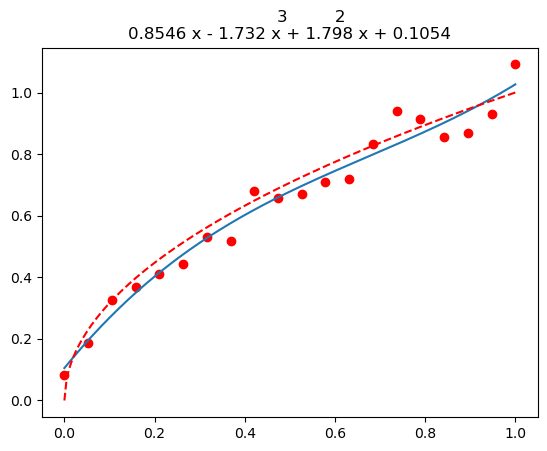

In [38]:
# 画图拟合多项式
def plot_polynomial_fit(x, y, deg):
    exp = np.poly1d(np.polyfit(x, y, deg))
    t = np.linspace(0, 1, 200)
    plt.plot(x, y, 'ro')  # 数据分布
    plt.plot(t, exp(t), '-')  # 拟合曲线
    plt.plot(t, np.sqrt(t), 'r--')  # 真实曲线，期望拟合曲线尽量接近真实曲线
    plt.title(str(exp))


# 3阶多项式拟合结果
plot_polynomial_fit(x, y, 3)
plt.show()

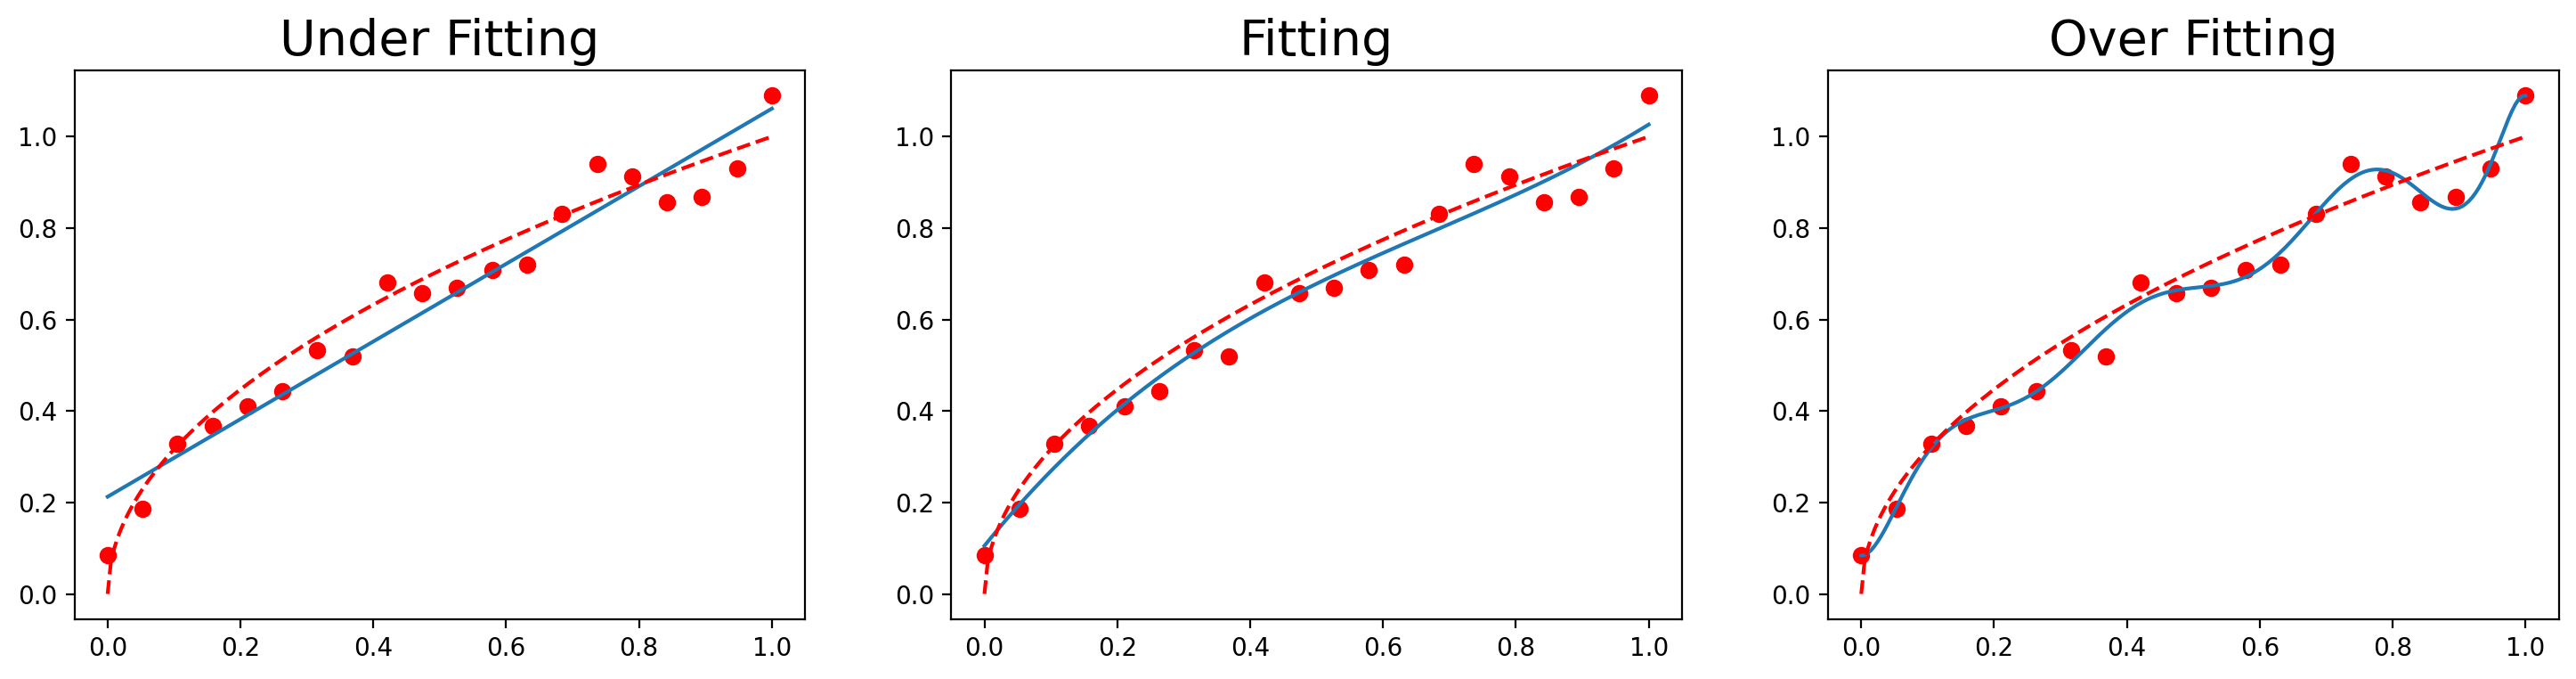

In [39]:
# 不同复杂度对比
degs = [1, 3, 10]
titles = ['Under Fitting', 'Fitting', 'Over Fitting']

plt.figure(figsize=(18, 4), dpi=200)
for idx, (deg, title) in enumerate(zip(degs, titles), 1):
    plt.subplot(1, 3, idx)
    plot_polynomial_fit(x, y, deg)
    plt.title(title, fontsize=20)

plt.show()

可以看到：
- 一阶多项式拟合的曲线无法捕捉数据集的分布规律，离数据集背后客观规律也很远
- 三阶多项式在这两方面表现良好
- 十阶多项式则在数据集分布规律捕捉上表现良好，但同样偏离真实曲线较远。

此时一阶多项式就是欠拟合，而十阶多项式则过分捕捉噪声数据的分布规律，而噪声之所以被称作噪声，是因为其分布本身毫无规律可言，或者其分布规律毫无价值（如此处噪声分布为均匀分布），因此就算十阶多项式在当前训练数据集上拟合度很高，但其捕捉到的无用规律无法推广到新的数据集上，因此该模型在测试数据集上执行过程将会有很大误差，即模型训练误差很小，但泛化误差很大，为过拟合。

基本结论如下：
- 模型欠拟合：训练集上误差较大
- 模型过拟合：训练集上误差较小，但测试集上误差较大

图示如下：

![model_complexity_prediction_error_of_train_and_test](../assets/model_complexity_prediction_error_of_train_and_test.png)

模型是否出现欠拟合或者过拟合和模型复杂度有很大关系：模型越复杂，越有能力捕捉训练集上的规律，因此如果模型欠拟合，可以通过提高模型复杂度来进一步捕捉规律，但同时也会面临模型过于复杂而导致过拟合的风险。深度学习中，模型复杂度和模型结构直接相关，隐藏层越多、每一层神经元越多、模型就越复杂，当然模型复杂度还和激活函数有关。模型拟合度优化是模型优化的核心，深度学习模型的一系列优化方法也基本是根据拟合度优化这一核心目标衍生出来的。
### 模型欠拟合举例

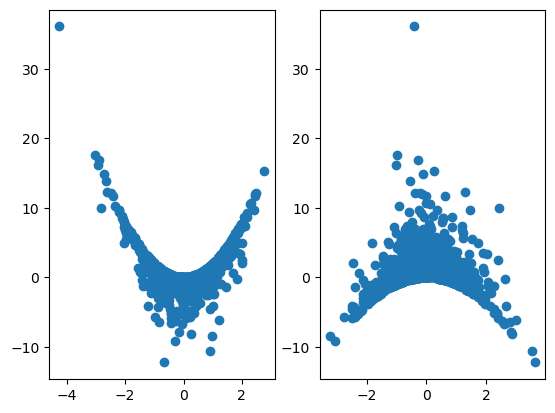

(torch.Size([1000, 2]), torch.Size([1000, 1]))

In [40]:
# 1.准备数据
# 创建数据集：y=2x1^2-x2^2
features, labels = gen_reg_data(w=(2, -1), deg=2, bias=False)
labels.unsqueeze_(-1)

# 可视化数据
plt.subplot(121)
plt.scatter(features[:, 0], labels)
plt.subplot(122)
plt.scatter(features[:, 1], labels)
plt.show()
features.shape, labels.shape

In [41]:
# 数据集的切分与加载
train_loader, test_loader = split_load_data(GenDataset, features, labels)
train_loader, test_loader

(<torch.utils.data.dataloader.DataLoader at 0x23fba975c10>,
 <torch.utils.data.dataloader.DataLoader at 0x23fba975bb0>)

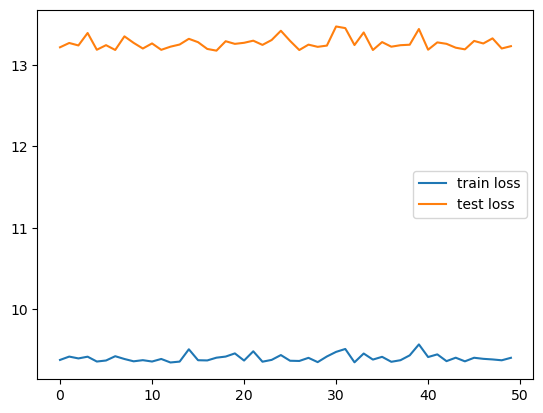

In [42]:
# 2.训练模型
# 定义简单线性回归模型
class LR(nn.Module):
    def __init__(self, in_features=2, out_features=1):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        out = self.linear(x)
        return out  # 没有激活函数


# 实例化模型
model = LR()

# 定义超参数
num_epochs = 50
lr = 0.03

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

# 迭代训练
train_losses, test_losses = [], []
for epoch in range(num_epochs):
    fit_one_epoch(model, criterion, optimizer, train_loader)
    train_losses.append(loss_with_loader(model, train_loader, criterion).item())
    test_losses.append(loss_with_loader(model, test_loader, criterion).item())

# 绘制图像
plt.plot(range(num_epochs), train_losses, label='train loss')
plt.plot(range(num_epochs), test_losses, label='test loss')
plt.legend()
plt.show()  # 训练集和测试集上的损失都较大，同时损失基本上没有减小的趋势，模型存在欠拟合

In [43]:
# 封装函数，记录训练过程中训练集和测试集上的损失变化情况
def train_test_model(model, train_loader, test_loader, criterion=nn.MSELoss, optimizer=optim.SGD,
                     evaluation=loss_with_loader, lr=0.03, num_epochs=20, cla=False):
    '''
    训练，并记录训练过程中训练集和测试集上的损失变化
    :param model: 待训练的模型
    :param train_loader: 训练数据集
    :param test_loader: 测试数据集
    :param criterion: 损失函数
    :param optimizer: 优化器
    :param evaluation: 数据集损失计算函数
    :param lr: 学习率
    :param num_epochs: 训练轮数
    :param cla: 是否是分类任务
    :return: 训练损失和测试损失
    '''
    criterion = criterion()
    optimizer = optimizer(model.parameters(), lr=lr)
    train_losses, test_losses = [], []
    for epoch in range(num_epochs):
        fit_one_epoch(model, criterion, optimizer, train_loader, cla)
        train_losses.append(evaluation(model, train_loader, criterion).item())
        test_losses.append(evaluation(model, test_loader, criterion).item())
    return train_losses, test_losses

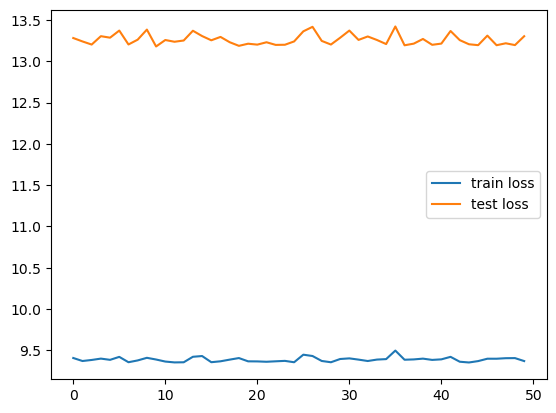

In [44]:
# 测试函数效果
model = LR()

# 训练模型
num_epochs = 50
train_losses, test_losses = train_test_model(model, train_loader, test_loader, num_epochs=num_epochs)

# 绘制图像
plt.plot(range(num_epochs), train_losses, label='train loss')
plt.plot(range(num_epochs), test_losses, label='test loss')
plt.legend()
plt.show()  # 与前面结果一致

## 3.解决模型欠拟合—提升模型复杂度
解决模型欠拟合的基本方法是提升模型复杂度，从而提升模型效果，从神经网络整体模型结构来看，提升复杂度有两种办法：
添加隐藏层，包括隐藏层层数和每一层隐藏层的神经元个数；
修改激活函数，在神经元内部对加权求和汇总之后的值进行更加复杂的处理。
### 增加模型层数

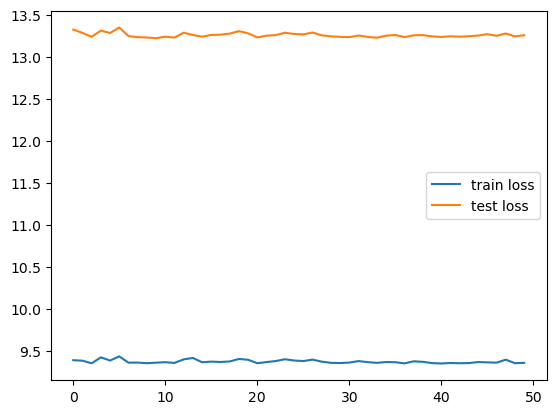

In [45]:
class TwoLayerLR(nn.Module):
    def __init__(self, in_features=2, hidden_dim=4, out_features=1):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, out_features)

    def forward(self, x):
        out = self.linear1(x)
        out = self.linear2(out)
        return out  # 无激活函数


# 实例化模型
model = TwoLayerLR()

# 训练模型
num_epochs = 50
train_losses, test_losses = train_test_model(model, train_loader, test_loader, num_epochs=num_epochs)

# 绘制图像
plt.plot(range(num_epochs), train_losses, label='train loss')
plt.plot(range(num_epochs), test_losses, label='test loss')
plt.legend()
plt.show()  # 与前面相比，损失并未明显下降，但是稳定性有所增加。叠加线性层只是对数据进行仿射变换，并不能实现拟合高次项

### 加入激活函数
在隐含层增加不同类型的激活函数，比较各个激活函数的效果。

In [46]:
# 定义带有激活函数的模型
class SigmoidLR(nn.Module):
    def __init__(self, in_features=2, hidden_dim=4, out_features=1, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, out_features, bias=bias)

    def forward(self, x):
        out = self.linear1(x)
        out = torch.sigmoid(out)
        out = self.linear2(out)
        return out


class TanhLR(nn.Module):
    def __init__(self, in_features=2, hidden_dim=4, out_features=1, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, out_features, bias=bias)

    def forward(self, x):
        out = self.linear1(x)
        out = torch.tanh(out)
        out = self.linear2(out)
        return out


class ReLULR(nn.Module):
    def __init__(self, in_features=2, hidden_dim=4, out_features=1, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, out_features, bias=bias)

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        return out

In [47]:
# 实例化模型
lr = TwoLayerLR()
sigmoid_lr = SigmoidLR()
tanh_lr = TanhLR()
relu_lr = ReLULR()

model_list = [lr, sigmoid_lr, tanh_lr, relu_lr]
name_list = ['lr', 'sigmoid_lr', 'tanh_lr', 'relu_lr']
model_list, name_list

([TwoLayerLR(
    (linear1): Linear(in_features=2, out_features=4, bias=True)
    (linear2): Linear(in_features=4, out_features=1, bias=True)
  ),
  SigmoidLR(
    (linear1): Linear(in_features=2, out_features=4, bias=True)
    (linear2): Linear(in_features=4, out_features=1, bias=True)
  ),
  TanhLR(
    (linear1): Linear(in_features=2, out_features=4, bias=True)
    (linear2): Linear(in_features=4, out_features=1, bias=True)
  ),
  ReLULR(
    (linear1): Linear(in_features=2, out_features=4, bias=True)
    (linear2): Linear(in_features=4, out_features=1, bias=True)
  )],
 ['lr', 'sigmoid_lr', 'tanh_lr', 'relu_lr'])

In [48]:
# 定义超参数
lr = 0.03
num_epochs = 100

# 定义损失函数
criterion = nn.MSELoss()

# 定义张量存储训练过程中的损失
train_losses, test_losses = torch.zeros(len(model_list), num_epochs), torch.zeros(len(model_list), num_epochs)

# 训练模型
for epoch in range(num_epochs):
    for idx, model in enumerate(model_list):
        optimizer = optim.SGD(model.parameters(), lr=lr)  # 优化器
        fit_one_epoch(model, criterion, optimizer, train_loader)
        train_losses[idx, epoch] = loss_with_loader(model, train_loader, criterion).item()
        test_losses[idx, epoch] = loss_with_loader(model, test_loader, criterion).item()

train_losses, test_losses

(tensor([[ 9.7274,  9.3789,  9.3683,  9.3935,  9.3787,  9.4150,  9.3936,  9.4136,
           9.3776,  9.3661,  9.3683,  9.3647,  9.3690,  9.3832,  9.3630,  9.4038,
           9.3999,  9.4054,  9.4008,  9.3581,  9.3749,  9.3770,  9.3790,  9.4027,
           9.4002,  9.4470,  9.3674,  9.3504,  9.3757,  9.3575,  9.3732,  9.3604,
           9.3866,  9.3950,  9.3640,  9.4064,  9.3861,  9.3858,  9.3707,  9.3897,
           9.3590,  9.3576,  9.3840,  9.3764,  9.4219,  9.3867,  9.3743,  9.3677,
           9.3634,  9.3770,  9.3700,  9.3532,  9.3795,  9.3701,  9.3599,  9.3618,
           9.3550,  9.3695,  9.4072,  9.3658,  9.4325,  9.3694,  9.3692,  9.3716,
           9.3670,  9.3621,  9.3628,  9.3543,  9.3549,  9.3818,  9.3854,  9.3518,
           9.3705,  9.3937,  9.3678,  9.3697,  9.3898,  9.3574,  9.3540,  9.3546,
           9.3622,  9.3559,  9.3612,  9.3550,  9.3613,  9.3721,  9.3698,  9.3574,
           9.3987,  9.3887,  9.3611,  9.3619,  9.3732,  9.3658,  9.3598,  9.3572,
           9.362

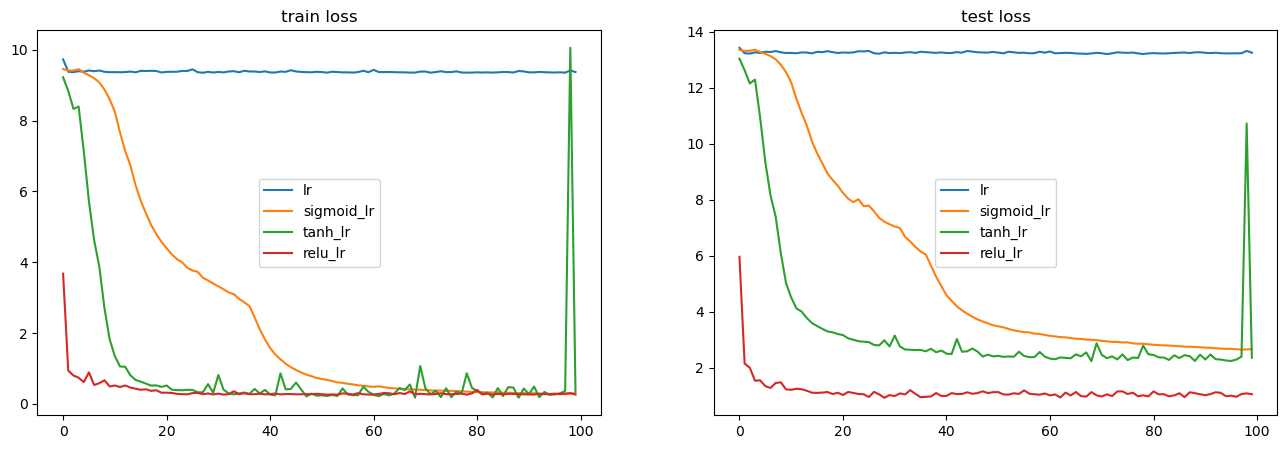

In [49]:
# 绘制损失函数图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()  # 相比于其它激活函数，ReLU收敛更快、损失更低、更加稳定

In [50]:
# 将模型对比封装为函数
def compare_models(model_list, train_loader, test_loader, criterion=nn.MSELoss, optimizer_class=optim.SGD,
                   evaluation=loss_with_loader, lr=0.03, num_epochs=20, cla=False):
    '''
    模型对比
    :param model_list: 模型对象列表
    :param train_loader: 训练集
    :param test_loader: 测试集
    :param criterion: 损失函数
    :param optimizer_class: 优化器
    :param evaluation: 数据集损失计算函数
    :param lr: 学习率
    :param num_epochs: 训练轮数
    :param cla: 是否是分类任务
    :return: 训练损失和测试损失
    '''
    criterion = criterion()

    train_losses, test_losses = torch.zeros(len(model_list), num_epochs), torch.zeros(len(model_list), num_epochs)

    # 训练模型
    for epoch in range(num_epochs):
        for idx, model in enumerate(model_list):
            optimizer = optimizer_class(model.parameters(), lr=lr)
            fit_one_epoch(model, criterion, optimizer, train_loader, cla=cla)
            train_losses[idx, epoch] = evaluation(model, train_loader, criterion).item()
            test_losses[idx, epoch] = evaluation(model, test_loader, criterion).item()

    return train_losses, test_losses

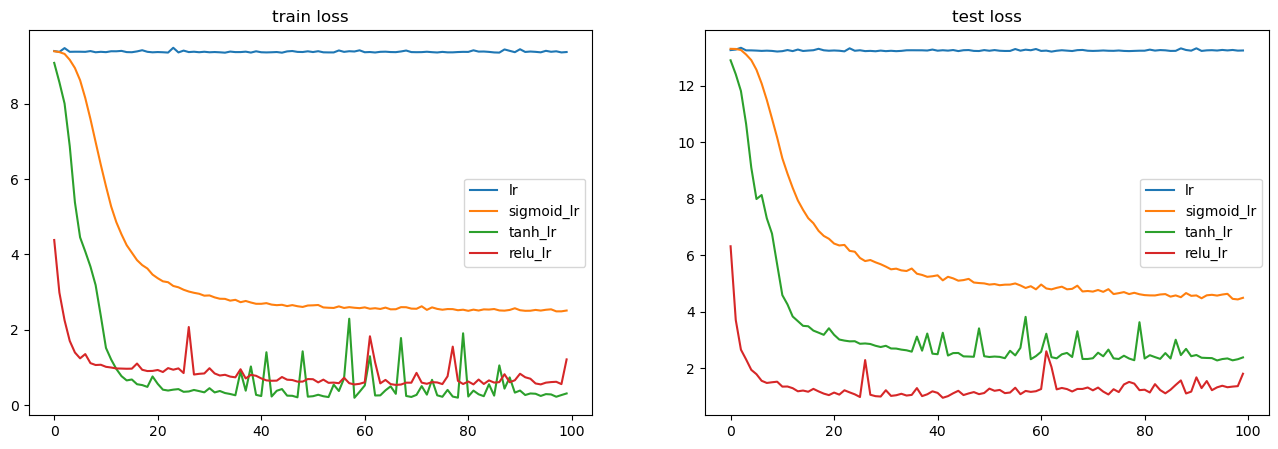

In [51]:
# 测试函数
lr = TwoLayerLR()
sigmoid_lr = SigmoidLR()
tanh_lr = TanhLR()
relu_lr = ReLULR()

model_list = [lr, sigmoid_lr, tanh_lr, relu_lr]
name_list = ['lr', 'sigmoid_lr', 'tanh_lr', 'relu_lr']

train_losses, test_losses = compare_models(model_list, train_loader, test_loader, num_epochs=num_epochs)

# 绘制损失函数图像
plt.figure(figsize=(16, 5))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()  # 效果与前面基本一致

## 4.构建复杂网络
### 增加ReLU激活函数层

In [52]:
# 2层ReLU
class L2ReLULR(nn.Module):
    def __init__(self, in_features=2, hidden_dim=4, out_features=1, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear3 = nn.Linear(hidden_dim, out_features, bias=bias)

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        return out


# 3层ReLU
class L3ReLULR(nn.Module):
    def __init__(self, in_features=2, hidden_dim=4, out_features=1, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear4 = nn.Linear(hidden_dim, out_features, bias=bias)

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        return out


# 4层ReLU
class L4ReLULR(nn.Module):
    def __init__(self, in_features=2, hidden_dim=4, out_features=1, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear4 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear5 = nn.Linear(hidden_dim, out_features, bias=bias)

    def forward(self, x):
        out = self.linear1(x)
        out = F.relu(out)
        out = self.linear2(out)
        out = F.relu(out)
        out = self.linear3(out)
        out = F.relu(out)
        out = self.linear4(out)
        out = F.relu(out)
        out = self.linear5(out)
        return out

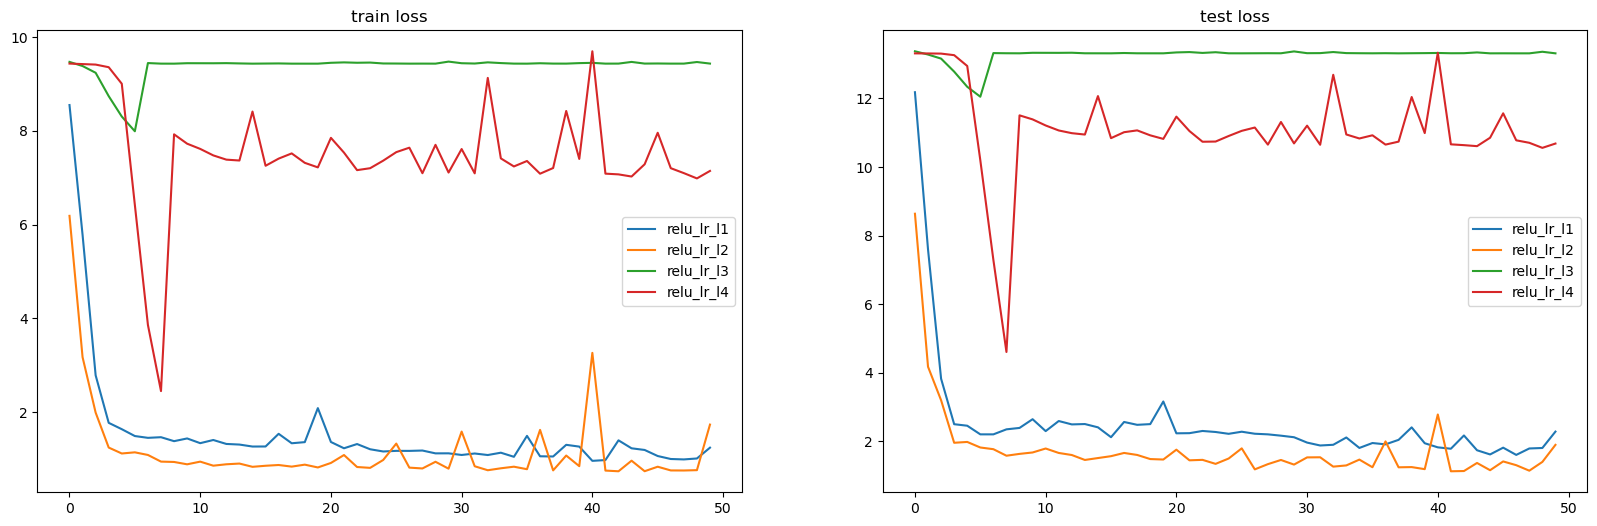

In [53]:
# 4个模型进行对比
# 模型实例化
relu_lr_l1 = ReLULR()
relu_lr_l2 = L2ReLULR()
relu_lr_l3 = L3ReLULR()
relu_lr_l4 = L4ReLULR()

model_list = [relu_lr_l1, relu_lr_l2, relu_lr_l3, relu_lr_l4]
name_list = ['relu_lr_l1', 'relu_lr_l2', 'relu_lr_l3', 'relu_lr_l4']

num_epochs = 50
train_losses, test_losses = compare_models(model_list, train_loader, test_loader, num_epochs=num_epochs)

# 绘制损失函数图像
plt.figure(figsize=(20, 6))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()

可以看到，在堆叠ReLU激活函数的过程中，模型效果并没有完全朝着预想的方向发展，损失不仅没有降低，3层和4层ReLU甚至出现了模型失效的情况，这充分说明，模型构建并非越复杂越好；同时，伴随模型复杂度增加，模型收敛速度变慢、收敛过程波动增加、甚至有可能出现模型失效的情况。深度学习本身就是一种构建复杂模型的方法，并且其核心价值就在于使用深度神经网络处理海量数据。从根本上来说，当前实验复杂模型出现问题并不是算法理论本身出了问题，而是我们缺乏了解决这些问题的“技术手段”，只有掌握了这些“技术手段”之后，才能真正构建运行高效、泛化能力强的模型。而这些技术手段，就是模型优化方法，这从侧面说明了优化算法的重要性。这里ReLU激活函数叠加后出现的模型失效问题，也就是**Dead ReLU Problem**。
### 增加Sigmoid激活函数层

In [54]:
# 2层Sigmoid
class L2SigmoidLR(nn.Module):
    def __init__(self, in_features=2, hidden_dim=4, out_features=1, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear3 = nn.Linear(hidden_dim, out_features, bias=bias)

    def forward(self, x):
        out = self.linear1(x)
        out = torch.sigmoid(out)
        out = self.linear2(out)
        out = torch.sigmoid(out)
        out = self.linear3(out)
        return out


# 3层Sigmoid
class L3SigmoidLR(nn.Module):
    def __init__(self, in_features=2, hidden_dim=4, out_features=1, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear4 = nn.Linear(hidden_dim, out_features, bias=bias)

    def forward(self, x):
        out = self.linear1(x)
        out = torch.sigmoid(out)
        out = self.linear2(out)
        out = torch.sigmoid(out)
        out = self.linear3(out)
        out = torch.sigmoid(out)
        out = self.linear4(out)
        return out


# 4层Sigmoid
class L4SigmoidLR(nn.Module):
    def __init__(self, in_features=2, hidden_dim=4, out_features=1, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear4 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear5 = nn.Linear(hidden_dim, out_features, bias=bias)

    def forward(self, x):
        out = self.linear1(x)
        out = torch.sigmoid(out)
        out = self.linear2(out)
        out = torch.sigmoid(out)
        out = self.linear3(out)
        out = torch.sigmoid(out)
        out = self.linear4(out)
        out = torch.sigmoid(out)
        out = self.linear5(out)
        return out

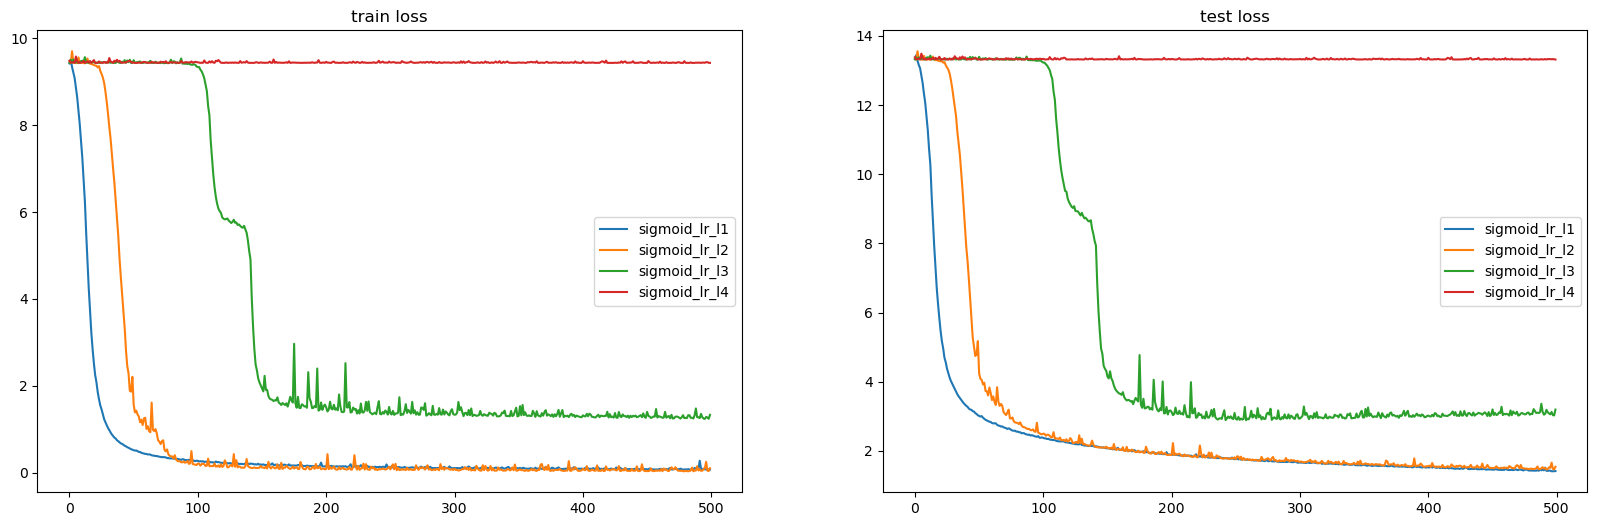

In [55]:
# 4个模型进行对比
# 模型实例化
sigmoid_lr_l1 = SigmoidLR()
sigmoid_lr_l2 = L2SigmoidLR()
sigmoid_lr_l3 = L3SigmoidLR()
sigmoid_lr_l4 = L4SigmoidLR()

model_list = [sigmoid_lr_l1, sigmoid_lr_l2, sigmoid_lr_l3, sigmoid_lr_l4]
name_list = ['sigmoid_lr_l1', 'sigmoid_lr_l2', 'sigmoid_lr_l3', 'sigmoid_lr_l4']

num_epochs = 500
train_losses, test_losses = compare_models(model_list, train_loader, test_loader, num_epochs=num_epochs)

# 绘制损失函数图像
plt.figure(figsize=(20, 6))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()

可以看到，Sigmoid激活函数的简单叠加也出现了很多问题，虽然没有像ReLU叠加一样出现损失大幅升高的情况，但对于1层、2层和3层Sigmoid来说，随着模型的复杂度增加，模型效果没有提升、反而有下降的趋势，收敛速度也严重下降，而4层Sigmoid更是一直没有收敛的趋势，问题更大。不过相比ReLU激活函数，整体收敛过程确实稍显稳定，而Sigmoid在2000年以前一直是最主流的激活函数。Sigmoid激活函数堆叠后出现的问题，本质上就是指数计算带来的**梯度消失**所导致的。
### 增加Tanh激活函数层

In [56]:
# 2层Tanh
class L2TanhLR(nn.Module):
    def __init__(self, in_features=2, hidden_dim=4, out_features=1, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear3 = nn.Linear(hidden_dim, out_features, bias=bias)

    def forward(self, x):
        out = self.linear1(x)
        out = torch.tanh(out)
        out = self.linear2(out)
        out = torch.tanh(out)
        out = self.linear3(out)
        return out


# 3层Tanh
class L3TanhLR(nn.Module):
    def __init__(self, in_features=2, hidden_dim=4, out_features=1, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear4 = nn.Linear(hidden_dim, out_features, bias=bias)

    def forward(self, x):
        out = self.linear1(x)
        out = torch.tanh(out)
        out = self.linear2(out)
        out = torch.tanh(out)
        out = self.linear3(out)
        out = torch.tanh(out)
        out = self.linear4(out)
        return out


# 4层Tanh
class L4TanhLR(nn.Module):
    def __init__(self, in_features=2, hidden_dim=4, out_features=1, bias=True):
        super().__init__()
        self.linear1 = nn.Linear(in_features, hidden_dim, bias=bias)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear3 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear4 = nn.Linear(hidden_dim, hidden_dim, bias=bias)
        self.linear5 = nn.Linear(hidden_dim, out_features, bias=bias)

    def forward(self, x):
        out = self.linear1(x)
        out = torch.tanh(out)
        out = self.linear2(out)
        out = torch.tanh(out)
        out = self.linear3(out)
        out = torch.tanh(out)
        out = self.linear4(out)
        out = torch.tanh(out)
        out = self.linear5(out)
        return out

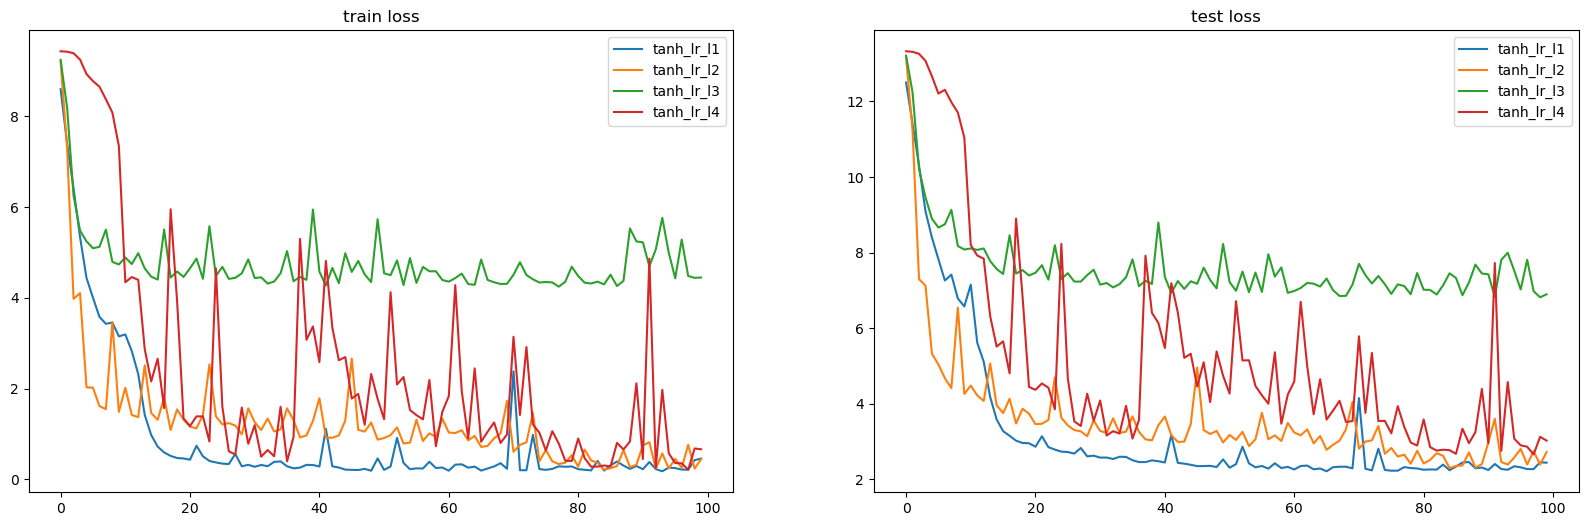

In [57]:
# 4个模型进行对比
# 模型实例化
tanh_lr_l1 = TanhLR()
tanh_lr_l2 = L2TanhLR()
tanh_lr_l3 = L3TanhLR()
tanh_lr_l4 = L4TanhLR()

model_list = [tanh_lr_l1, tanh_lr_l2, tanh_lr_l3, tanh_lr_l4]
name_list = ['tanh_lr_l1', 'tanh_lr_l2', 'tanh_lr_l3', 'tanh_lr_l4']

num_epochs = 100
train_losses, test_losses = compare_models(model_list, train_loader, test_loader, num_epochs=num_epochs)

# 绘制损失函数图像
plt.figure(figsize=(20, 6))
plt.subplot(121)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), train_losses[idx], label=name)
plt.title('train loss')
plt.legend()
plt.subplot(122)
for idx, name in enumerate(name_list):
    plt.plot(range(num_epochs), test_losses[idx], label=name)
plt.title('test loss')
plt.legend()
plt.show()

Tanh激活函数叠加效果中规中矩，1层和2层Tanh的效果明显更好，损失值基本一致、收敛速度基本一致、收敛过程稳定性较好，也证明模型结果较为可信，而3层和4层Tanh则表现出了和前面两种激活函数在叠加过程中所出现的类似的问题，同时对于Tanh来说，最明显的问题是出现了剧烈波动，甚至出现了“跳跃点”。Tanh激活函数堆叠所导致的迭代过程剧烈波动的问题称为**迭代不平稳**，需要通过优化迭代过程来解决。
## 5.神经网络结构选择策略
### 参数和超参数
在机器学习中，参数其实分为两类，即**参数和超参数**，一个影响模型的变量是参数还是超参数，核心区别就在于这个变量的取值能否通过一个严谨的数学过程求出，如果可以，就是参数，否则就是超参数。例如，对于简单线性回归中的自变量的权重，我们通过最小二乘法或者梯度下降算法，能够求得一组全域最优解，因此自变量的权重就是参数，同样，复杂神经网络中的神经元连接权重也是参数。除此以外，还有一类影响模型效果的变量却无法通过构建数学方程、然后采用优化算法算得最优解，典型的如训练集和测试集划分比例、神经网络的层数、每一层神经元个数等，这些变量同样也会影响模型效果，但由于无法通过数学过程求得最优解，很多时候都是凭借经验设置数值，然后根据建模结果再进行手动调节，这类变量我们称其为超参数。
在实际机器学习建模过程中超参数出现的场景并不比参数出现的场景少，甚至很多时候，超参数的边界也和我们如何看待一个模型息息相关，例如，如果把“选什么模型”也看成是一个最终影响建模效果的变量，那这个变量也是一个超参数。也就是说，超参数也就是由“人来决策”的部分场合，而这部分也是体现算法工程师核心竞争力的环节。参数通过优化算法计算出结果，而机器学习发展至今，也出现了很多辅助超参数调节的工具，比如网格搜索（Grid Search）、AutoML等。
### 神经网络模型结构选择策略
在模型结构选择方面，根据经验，有一些基本结论：

（1）层数选择方面
- 三层以内：模型效果会随着层数增加而增加；
- 三层至六层：随着层数的增加，模型的稳定性迭代的稳定性会受到影响，并且这种影响是随着层数增加“指数级”增加的，此时我们就需要采用一些优化方法对输入数据、激活函数、损失函数和迭代过程进行优化，一般来说在六层以内的神经网络在通用的优化算法配合下，是能够收敛至一个较好的结果的；
- 六层以上：在模型超过六层之后，优化方法在一定程度上仍然能够辅助模型训练，但此时保障模型正常训练的更为核心的影响因素，就变成了数据量本身和算力。神经网络模型要迭代收敛至一个稳定的结果，所需的epoch是随着神经网络层数增加而增加的，也就是说神经网络模型越复杂，收敛所需迭代的轮数就越多，此时所需的算力也就越多。而另一方面，伴随着模型复杂度增加，训练所需的数据量也会增加，如果是复杂模型应用于小量样本数据，则极有可能会出现“过拟合”的问题从而影响模型的泛化能力。当然，伴随着模型复杂度提升、所需训练数据增加，对模型优化所采用的优化算法也会更加复杂。也就是说，六层以内神经网络应对六层以上的神经网络模型，我们需要更多的算力支持、更多的数据量、以及更加复杂的优化手段支持，因此如果不是借助已有经典模型而是自己构建模型的话，不建议搭建六层以上的神经网络模型。

（2）每一层神经元个数选择方面：输入层的神经元个数就是特征个数，而输出层神经元个数，如果是回归类问题或者是逻辑回归解决二分类问题，输出层就只有一个神经元，而如果是多分类问题，输出层神经元个数就是类别总数。而隐藏层神经元个数，可以按照最多不超过输入特征的2-4倍进行设置，默认连接方式是全连接，每一个隐藏层可以设置相同数量的神经元。其实对于神经元个数设置来说，后期是有调整空间的，哪怕模型创建过程神经元数量有些“饱和”，也可以通过丢弃法（优化方法的一种）对隐藏层神经元个数和连接方式进行修改。对于某些非结构化数据来说，隐藏层神经元个数也会根据数据情况来进行设置，如神经元数量和图像关键点数量匹配等。

同时，经验是对过去的一般情况的总结，并不代表所有情况，同时也不代表对未来的预测。同时，这些经验适用于自定义神经网络模型的情况，很多针对某一类问题的经典深度学习架构会有单独的规则。
### 激活函数使用的单一性
通常来说，是不会出现多种激活函数应用于一个神经网络中的情况的。主要原因并不是因为模型效果就一定会变差，而是如果几种激活函数效果类似，那么交叉使用几种激活函数其实效果和使用一种激活函数区别不大，而如果几种激活函数效果差异非常明显，那么这几种激活函数的堆加就会使得模型变得非常不可控。同时，目前工业界所掌握的、针对激活函数的优化算法都是针对某一种激活函数来使用的，激活函数的交叉使用会令这些优化算法失效。因此，尽管机器学习模型是“效果为王”，但在基础理论没有进一步突破之前，不推荐在一个神经网路中使用多种激活函数。
## 6.损失函数的随机创建现象
一般我们可能会认为，损失函数从始至终都不变，梯度下降迭代过程就是“从山顶走到山脚”，一步步找到最小值。同时也会发现，迭代过程中损失函数下降，但模型评估指标却出现波动。实际上，在使用**小批量梯度下降**时，损失不是处于稳定下降的趋势的，而是可能会出现波动。

通过实例来说明这个问题，有一组数据如下：

|x|y|
| :------: | :------: |
| 1 | 2 |
| 3 | 5 |
| 6 | 4 |
| 8 | 3 |

对于上面这组数据，使用$y=wx$进行拟合，并使用MSE作为损失函数，使用小批量梯度下降进行求解，每次使用2条数据进行迭代，则每个epoch有2个batch。
第1个hatch的损失函数：$\begin{align} SSE_{(1)} = (2-1*w)^2 + (5-3*w)^2  = w^2-4w+4+9w^2-30w+25 = 10w^2-34w+29 \end{align}$
第1个batch的梯度：$\begin{align} grad_{(1)} = \frac{\partial{SSE_{(1)}}}{\partial{(w)}} = 20w-34 \end{align}$
第2个hatch的损失函数：$\begin{align} SSE_{(2)} = (4-6*w)^2 + (3-8*w)^2 = 36w^2-48w+16+64w^2-48w+9 = 100w^2-96w+25 \end{align}$
第2个batch的梯度：$\begin{align} grad_{(2)} = \frac{\partial{SSE_{(1)}}}{\partial{(w)}} = 200w-96 \end{align}$
一个epoch的损失是各个batch的损失值之和：$\begin{align} SSE = (2-1*w)^2 + (5-3*w)^2 + (4-6w)^2 + (3-8w)^2 = SSE_{(1)}+SSE_{(2)} = 110w^2-130w+54 \end{align}$

迭代过程要求每一次迭代损失函数都降低，但可以看到，第一轮epoch迭代第一次时，$SSE_1$能够顺利降低，但$SSE_2$和$SSE$并不一定，同理，第一轮epoch迭代第二次时，$SSE_2$能够顺利降低，但$SSE_1$和$SSE$并不一定。虽然我们相信数据整体特性应该保持一致，大概率来说其中一个损失函数减少，其他损失函数也会减少，但毕竟方程不同，这其中确实也存在着一定的不确定性。下面通过代码进行实验。

In [58]:
# SSE1损失函数
sse1 = lambda x: 10 * x ** 2 - 34 * x + 29
# SSE2损失函数
sse2 = lambda x: 100 * x ** 2 - 96 * x + 25
# SSE损失函数
sse = lambda x: 110 * x ** 2 - 130 * x + 54
# SSE1梯度计算函数
grad1 = lambda x: 20 * x - 34
# SSE2梯度计算函数
grad2 = lambda x: 200 * x - 96

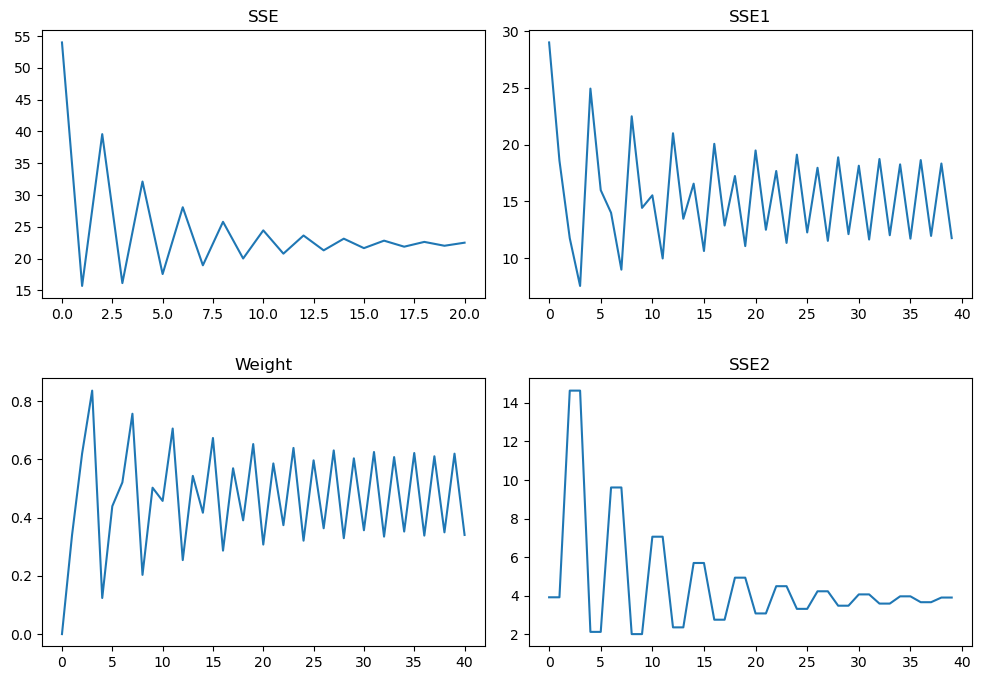

In [59]:
# 定义超参数
w = 0  # w初始化
lr = 0.01
num_epochs = 20

# 创建列表记录训练过程
weights = [w]
losses = []
losses1 = []
losses2 = []

# 开始迭代
for epoch in range(num_epochs):
    # 每一个epoch开始时的整体损失
    losses.append(sse(w))
    # 第1个batch
    losses1.append(sse1(w))  # 迭代前计算当前batch的SSE
    w -= lr * grad1(w)  # 更新参数
    weights.append(w)  # 记录参数
    losses1.append(sse1(w))  # 迭代后计算当前batch的SSE
    # 第2个batch
    losses2.append(sse2(w))  # 迭代前计算当前batch的SSE
    w -= lr * grad2(w)  # 更新参数
    weights.append(w)  # 记录参数
    losses2.append(sse2(w))  # 迭代后计算当前batch的SSE

# 记录最终的SSE
losses.append(sse(w))

# 可视化
fig = plt.figure(figsize=(12, 8))
fig.subplots_adjust(wspace=0.1, hspace=0.3)
plt.subplot(221)
plt.plot(range(num_epochs + 1), losses)
plt.title('SSE')
plt.subplot(223)
plt.plot(range(len(weights)), weights)
plt.title('Weight')
plt.subplot(222)
plt.plot(range(num_epochs * 2), losses1)
plt.title('SSE1')
plt.subplot(224)
plt.plot(range(num_epochs * 2), losses2)
plt.title('SSE2')
plt.show()

可以看到，每一轮的内部两次迭代，对于SSE1和SSE2来说变化方向是相反的，说明一个epoch内部的不同batch之间的目标是不一致的，甚至可能是相反的，同时每一轮之间SSE1和SSE2整体趋势是下降的，但是都会出现波动，原因也是因为其他batch的损失函数计算出来的w不一定能有效帮助当前batch损失函数降低取值，因此整体SSE也是在波动中趋于稳定的，权重也随着不同epoch和batch处于动态变化的状态。由此可知，在模型训练过程中，明明应该“整体向好”，但不管是损失函数还是模型指标，都可能出现波动的情况，这些都是小批量梯度下降的随机性带来的。

小批量梯度下降算法捕捉局部规律：带入部分数据还是带入全部数据是相对的，在小批量梯度下降中，某一次迭代虽然是带入了全部训练数据集的一部分，但如果我们把这部分数据看成全部，就相当于是带入了全部数据进行训练。所有的训练都是为了捕捉规律，因此我们可以把某一次迭代看成是模型在捕捉这一部分数据的“全部规律”，但由于这部分数据只是所有训练数据的一部分，因此模型还只是捕捉了局部规律。从这个角度来说，小批量梯度下降是希望通过捕捉一个个“小批”数据的局部规律最终构成整个数据集的整体规律。
小批量梯度下降算法有效性：之所以通过捕捉局部规律最后能够更好的把握整体规律，是因为小批量梯度下降能够跨越局部最小值点，而根本原因则是对于某些“小批”数据来说，由于局部规律和整体规律存在差异性，整体的局部最小值点对于当前“小批”数据来说根本就不是局部最小值点（毕竟不同数据的损失函数不同），因此带入该“小批”数据时候就有可能直接跨越该点，也就是说，小批量梯度下降无法跨越小批数据对应的损失函数的最小值点，但在下降的过程中却有可能偶然帮助整体损失函数跨越最小值点，这就是借助随机性解决问题的典型。

由于小批量梯度下降每次带入的数据不同从而导致损失函数不同进而导致模型结果波动以外，还有一种可能也会导致模型结果波动，那就是目标函数和模型评估指标不一致。这种情况在分类问题中非常常见，常见的分类问题中损失函数是交叉熵损失函数，代表极大似然估计的概率值，而模型评估指标是准确率，代表最终预测准确的个数占比，而在实际建模过程中，确实有可能存在极大似然估计概率值增加但准确率不变甚至降低的情况（牺牲了某条数据的判别结果但换来了其他很多条数据的极大似然估计概率值大幅提升），从而导致训练过程模型评估指标波动。

需要注意，**随机性是把双刃剑**：当我们借助随机性解决问题的时候，同样也会面临随机性带来的麻烦，由于一旦开始随机，整个迭代过程都会变得不可控，此后我们只能通过各种方法将这个随机过程尽可能按照我们的意愿执行，这也就是一系列优化方法的由来。